In [1]:
from hydra.utils import instantiate
import numpy as np
from omegaconf import OmegaConf
import pandas as pd
from pathlib import Path
from sklearn.metrics import roc_auc_score
import torch
from torch import nn
from tqdm import tqdm
import hydra
import timm

In [153]:
timm.create_model('tf_efficientnet_b0')

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
    )
    (1): Sequential(
      (0

In [2]:
import json

In [18]:
#timm.create_model("coat_tiny")

In [3]:
#import albumentations as A
import matplotlib.pyplot as plt
def plot_image(df, idx):
    ids = df.id.iloc[idx]
    im = np.load(f"data/{df.flag.iloc[idx]}/{ids[0]}/{ids}.npy")[[0, 2, 4]].astype(np.float32)
    im = np.vstack(im)
    im -= im.min()
    im /= im.max()
    plt.figure(figsize=(15, 15))
    plt.imshow(im)
    plt.show()

In [4]:
import pandas as pd
oof_public = pd.read_csv("data/ensemble_oof.csv")
test_public = pd.read_csv("data/submission.csv")
test_public.head()

id    target
0  00034db451c4  0.008421
1  0006316b5ca0  0.004180
2  0006a953d21b  0.031801
3  0008a33d6695  0.026555
4  00095b5119fc  0.013587

In [18]:
oof_mk = pd.read_csv("data/predictions/effb0_norm4_p035_moreaugs/tf_efficientnet_b0_ns/oof_preds.csv")
oof_mk2 = pd.read_csv("data/predictions/effb0_ubeta1_p10/tf_efficientnet_b0_ns/oof_preds.csv")
oof_mk3 = pd.read_csv("data/predictions/effb0_ubeta1_p10_dropout/tf_efficientnet_b0_ns/oof_preds.csv")
oof_mk4 = pd.read_csv("data/predictions/effb0_ubeta05_p10_drop_forback_augs2/tf_efficientnet_b0_ns/oof_preds.csv")
oof_mk5 = pd.read_csv("data/predictions/effb0_ubeta05_p10_augs2_backattn/tf_efficientnet_b0_ns/oof_preds.csv")

In [19]:
tr = pd.read_csv("data/train_labels.csv")
oof_mk['target'] = oof_mk.id.map(tr.set_index('id')['target'])
oof_mk['public_preds'] = oof_mk.id.map(oof_public.set_index('id')['target'])
oof_mk['preds2'] = oof_mk.id.map(oof_mk2.set_index('id')['preds'])
oof_mk['preds3'] = oof_mk.id.map(oof_mk3.set_index('id')['preds'])
oof_mk['preds4'] = oof_mk.id.map(oof_mk4.set_index('id')['preds'])
oof_mk['preds5'] = oof_mk.id.map(oof_mk5.set_index('id')['preds'])

targets = oof_mk.target.values

In [35]:
from sklearn.metrics import roc_auc_score
from scipy.stats import gmean
import numpy as np
print(roc_auc_score(targets, gmean([oof_mk.preds.values, oof_mk.preds2.values, oof_mk.preds3.values, oof_mk.preds5.values, oof_mk.public_preds.values], 0)))
# print(roc_auc_score(targets, gmean([oof_mk.preds.values, oof_mk.preds2.values, oof_mk.preds3.values, oof_mk.public_preds.values], 0)))


0.9930989506724003


In [37]:
from sklearn.metrics import confusion_matrix
preds = gmean([oof_mk.preds.values, oof_mk.preds2.values, oof_mk.preds3.values, oof_mk.preds5.values, oof_mk.public_preds.values], 0)
confusion_matrix(targets, preds > 0.4)

array([[45466,     5],
       [  342,  4352]])

In [38]:
oof_mk['preds_ee'] = preds

In [39]:
oof_mk.loc[(preds < 0.5) & (targets == 1)]

id  target    preds  public_preds    preds2    preds3  \
96     01e2ca653485       1  0.62500      0.273124  0.366700  0.459200   
239    04c543136917       1  0.24740      0.039788  0.133700  0.363300   
267    05502cd1a31d       1  0.60350      0.410207  0.039520  0.598600   
853    10d425c3301e       1  0.25600      0.043442  0.020570  0.240800   
884    117bb6ad7176       1  0.59300      0.589119  0.309000  0.411600   
...             ...     ...      ...           ...       ...       ...   
49348  f057dddfa8a4       1  0.80960      0.046728  0.682000  0.722700   
49847  f979f9cf68f6       1  0.85550      0.069983  0.495600  0.337200   
49904  fad6049666be       1  0.01381      0.014258  0.001841  0.002170   
49916  fb06e1cb4ecc       1  0.02740      0.027747  0.005188  0.006157   
50159  ffde38ad6974       1  0.84300      0.013561  0.466300  0.322800   

        preds4  preds5  preds_ee  
96     0.13960  0.7275  0.461400  
239    0.59860  0.6670  0.199865  
267    0.16400  0.4033  0.298299  
853    0.07434  0.1881  0.100713  
884    0.48630  0.6377  0.490300  
...        ...     ...       ...  
49348  0.93600  0.8467  0.436179  
49847  0.98140  0.8564  0.385995  
49904  0.02322  0.0443  0.008099  
49916  0.04828  0.0678  0.017511  
50159  0.36060  0.5757  0.250717  

[413 rows x 9 columns]

In [40]:
oof_mk.loc[oof_mk.target == 1].sample(10)

id  target    preds  public_preds   preds2    preds3  \
20979  ab31cc18735d       1  0.94970      0.933289  0.80960  0.792000   
9539   c2335bca12aa       1  0.98830      0.932508  0.79300  0.742000   
309    06343b60e795       1  0.89650      0.928863  0.76400  0.753400   
31529  81edaf702ceb       1  0.07385      0.027909  0.04828  0.172200   
43524  7a0897edaca8       1  0.06250      0.035537  0.02963  0.015015   
27397  2f022b0bf7da       1  0.92970      0.909146  0.75900  0.829600   
12425  fd6036c80191       1  0.95500      0.925448  0.75050  0.777300   
48922  e7e4cdb4dc3d       1  0.97360      0.929981  0.71200  0.750000   
19469  8c0b73703455       1  0.92400      0.865636  0.80800  0.724000   
15028  31f3b0bd6f20       1  0.95000      0.861121  0.80860  0.785000   

        preds4   preds5  preds_ee  
20979  0.95900  0.98930  0.891221  
9539   1.00000  0.99400  0.883733  
309    1.00000  0.97170  0.858283  
31529  0.20240  0.09924  0.070165  
43524  0.04413  0.09510  0.039319  
27397  1.00000  1.00000  0.881490  
12425  1.00000  0.99070  0.874274  
48922  0.99600  0.99000  0.862991  
19469  0.50730  0.99800  0.858732  
15028  0.99370  0.98630  0.874742

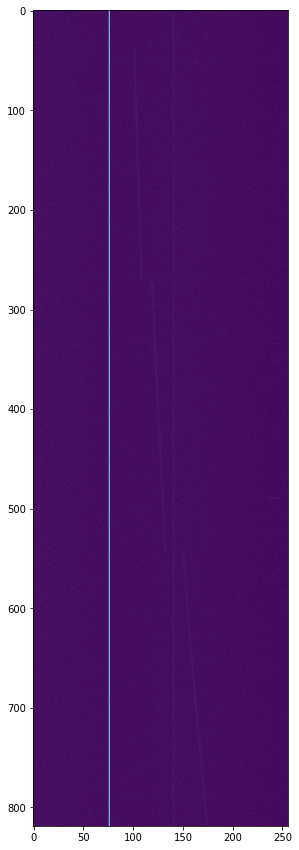

In [41]:
oof_mk['flag'] = 'train'
plot_image(oof_mk, 31670)

In [42]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
cvlist = StratifiedKFold(shuffle=True, random_state=123456).split(oof_mk, oof_mk.target)
X = oof_mk[['preds', 'preds2', 'preds3', 'preds4']].values
y = oof_mk.target.values
y_preds = np.zeros_like(y, dtype=np.float32)
for tridx, vlidx in cvlist:
    xtr, ytr = X[tridx], y[tridx]
    xvl, yvl = X[vlidx], y[vlidx]
    model = lgb.LGBMClassifier(boosting_type='dart', n_estimators=400, min_child_samples=20, learning_rate=0.1, reg_alpha=0.1, reg_lambda=.1, num_leaves=4, subsample=0.5, colsample_bytree=0.5, max_bin=256)
    model.fit(xtr, ytr, eval_set=[(xvl, yvl)], eval_metric='auc', verbose=50, early_stopping_rounds=100)
    y_preds[vlidx] = model.predict_proba(xvl)[:, 1]
print(y_preds)
roc_auc_score(y, y_preds)

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's auc: 0.991754	valid_0's binary_logloss: 0.0332241
[100]	valid_0's auc: 0.992046	valid_0's binary_logloss: 0.029928
[150]	valid_0's auc: 0.992245	valid_0's binary_logloss: 0.0279472
[200]	valid_0's auc: 0.992091	valid_0's binary_logloss: 0.0264127
[250]	valid_0's auc: 0.992032	valid_0's binary_logloss: 0.025996
[300]	valid_0's auc: 0.992241	valid_0's binary_logloss: 0.0259496
[350]	valid_0's auc: 0.992289	valid_0's binary_logloss: 0.0258648
[400]	valid_0's auc: 0.992308	valid_0's binary_logloss: 0.0258267
[50]	valid_0's auc: 0.992112	valid_0's binary_logloss: 0.0321163
[100]	valid_0's auc: 0.992219	valid_0's binary_logloss: 0.028983


/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[150]	valid_0's auc: 0.992253	valid_0's binary_logloss: 0.0269739
[200]	valid_0's auc: 0.992471	valid_0's binary_logloss: 0.0253724
[250]	valid_0's auc: 0.992277	valid_0's binary_logloss: 0.0251837
[300]	valid_0's auc: 0.992161	valid_0's binary_logloss: 0.0251866
[350]	valid_0's auc: 0.992224	valid_0's binary_logloss: 0.0250671
[400]	valid_0's auc: 0.992332	valid_0's binary_logloss: 0.0249984


/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's auc: 0.992383	valid_0's binary_logloss: 0.0326983
[100]	valid_0's auc: 0.992657	valid_0's binary_logloss: 0.02952
[150]	valid_0's auc: 0.992451	valid_0's binary_logloss: 0.0274797
[200]	valid_0's auc: 0.992691	valid_0's binary_logloss: 0.0259406
[250]	valid_0's auc: 0.992855	valid_0's binary_logloss: 0.0255993
[300]	valid_0's auc: 0.992971	valid_0's binary_logloss: 0.0254581
[350]	valid_0's auc: 0.992859	valid_0's binary_logloss: 0.025472
[400]	valid_0's auc: 0.992983	valid_0's binary_logloss: 0.0253306
[50]	valid_0's auc: 0.991816	valid_0's binary_logloss: 0.0309132
[100]	valid_0's auc: 0.991848	valid_0's binary_logloss: 0.0278974


/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[150]	valid_0's auc: 0.992036	valid_0's binary_logloss: 0.0259422
[200]	valid_0's auc: 0.992247	valid_0's binary_logloss: 0.024283
[250]	valid_0's auc: 0.992388	valid_0's binary_logloss: 0.0239628
[300]	valid_0's auc: 0.992508	valid_0's binary_logloss: 0.0238055
[350]	valid_0's auc: 0.992528	valid_0's binary_logloss: 0.0237564
[400]	valid_0's auc: 0.992402	valid_0's binary_logloss: 0.023785


/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/lightgbm/callback.py:183: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[50]	valid_0's auc: 0.991675	valid_0's binary_logloss: 0.0326763
[100]	valid_0's auc: 0.991762	valid_0's binary_logloss: 0.0295402
[150]	valid_0's auc: 0.991778	valid_0's binary_logloss: 0.0275673
[200]	valid_0's auc: 0.991958	valid_0's binary_logloss: 0.0260274
[250]	valid_0's auc: 0.992018	valid_0's binary_logloss: 0.0256158
[300]	valid_0's auc: 0.991978	valid_0's binary_logloss: 0.0255743
[350]	valid_0's auc: 0.992076	valid_0's binary_logloss: 0.0254791
[400]	valid_0's auc: 0.992063	valid_0's binary_logloss: 0.0253864
[0.00246953 0.0079329  0.00076452 ... 0.00600451 0.00894228 0.00049085]


0.9923454773709368

In [98]:
test_mk = pd.read_csv("data/predictions/effb0_norm4_p035_moreaugs/tf_efficientnet_b0_ns/test_preds.csv")
test_mk['preds'] = test_mk['target'].copy()
test_mk2 = pd.read_csv("data/predictions/effb0_ubeta1_p10/tf_efficientnet_b0_ns/test_preds.csv")
test_mk3 = pd.read_csv("data/predictions/effb0_ubeta1_p10_dropout/tf_efficientnet_b0_ns/test_preds.csv")
test_mk4 = pd.read_csv("data/predictions/effb0_ubeta05_p10_drop_forback_augs2/tf_efficientnet_b0_ns/test_preds.csv")
test_mk5 = pd.read_csv("data/predictions/effb0_ubeta05_p10_augs2_backattn/tf_efficientnet_b0_ns/test_preds.csv")

test_mk['preds_pub'] = test_mk.id.map(test_public.set_index('id')['target'])
test_mk['preds2'] = test_mk.id.map(test_mk2.set_index('id')['target'])
test_mk['preds3'] = test_mk.id.map(test_mk3.set_index('id')['target'])
test_mk['preds4'] = test_mk.id.map(test_mk4.set_index('id')['target'])
test_mk['preds5'] = test_mk.id.map(test_mk5.set_index('id')['target'])

easter_ids = ['2503d7f6e5c4',
        '805a7f4cac38',
        'e05a5e667d06',
        '4f7bb8cf2d15',
        '1397c4ab0e5c',
        '1725ceec6de4',
        '6c12bab0aeb4',
        '1e6e43ddc15a',
        '72bc12d576e2']
test_mk['target'] = gmean([test_mk.target.values, test_mk.preds2.values, test_mk.preds3.values, test_mk.preds5.values, test_mk.preds_pub.values], 0)
test_mk.loc[test_mk.id.isin(easter_ids), 'target'] = 1.0

test_mk[['id', 'target']].to_csv("data/test_v1v2v3v4_pub_avg.csv", index=False)

In [99]:
oof_mk.head()

id  target     preds  public_preds    preds2    preds3   preds4  \
0  00034abb3629       0  0.010506      0.013472  0.006264  0.005730  0.02786   
1  000453852fda       0  0.034520      0.015374  0.011750  0.017150  0.05902   
2  00047dfc96a9       0  0.011920      0.006511  0.001216  0.006775  0.02771   
3  0005be4d0752       0  0.042100      0.023197  0.004410  0.012420  0.03370   
4  0008fcc2f87d       0  0.010900      0.003093  0.001271  0.002130  0.02498   

    preds5  preds_ee   flag  
0  0.03952  0.011496  train  
1  0.07900  0.024286  train  
2  0.03723  0.007505  train  
3  0.05603  0.019740  train  
4  0.02660  0.004754  train

In [100]:
test_mk.head()

id    target    preds  preds_pub    preds2    preds3   preds4  \
0  00034db451c4  0.012278  0.01284   0.008421  0.006386  0.005566  0.08010   
1  0006316b5ca0  0.009906  0.02773   0.004180  0.005116  0.002907  0.04065   
2  0006a953d21b  0.025997  0.02460   0.031801  0.012820  0.034420  0.03880   
3  0008a33d6695  0.028986  0.04553   0.026555  0.018140  0.013084  0.05566   
4  00095b5119fc  0.013832  0.02847   0.013587  0.004814  0.005800  0.03918   

    preds5  
0  0.07260  
1  0.05533  
2  0.03440  
3  0.07130  
4  0.04688

In [101]:
test_labels = pd.read_csv("data/test_labels.csv")
test_labels.head()

id  target
0  00034db451c4     0.0
1  0006316b5ca0     0.0
2  0006a953d21b     0.0
3  0008a33d6695     0.0
4  00095b5119fc     0.0

In [102]:
print(roc_auc_score(test_labels.target.values, test_mk.preds))  # 0.9920, 0.979, 0.9866
print(roc_auc_score(test_labels.target.values, test_mk.preds2))  # 0.9910, 0.980, 0.9853
print(roc_auc_score(test_labels.target.values, test_mk.preds3))  # 0.9912, 0.981, 0.9860
print(roc_auc_score(test_labels.target.values, test_mk.preds4))  # 0.9887, 0.978, 0.9840

print(roc_auc_score(test_labels.target.values, test_mk.target))  # 0.9925, 0.981, 0.9871


0.9866749838264567
0.9853225177749525
0.9859771182515205
0.9840622151560444
0.9875420034690143


In [87]:
roc_auc_score(test_labels.target.values, test_mk.preds_pub)

0.9855119514916703

In [17]:
tmp = pd.read_csv("data/predictions/effb0_ubeta05_p10_augs2_backattn/tf_efficientnet_b0_ns/test_preds.csv")
roc_auc_score(test_labels.target.values, tmp.target.values)

0.9837674922593491

In [95]:
test_mk.loc[(test_mk.target > 0.4) & (test_mk.target < 0.5)].sample(10)target

id    target  preds_pub  preds2  preds3  preds4  flag
32229  e6676e1b1de5  0.454595   0.503948  0.3174  0.3320  0.6800  test
23232  a63465d4a9fc  0.482846   0.504196  0.3320  0.3306  0.8145  test
22642  a210b358634a  0.474456   0.205389  0.4410  0.4106  0.5225  test
16064  7330ec277f5d  0.486288   0.299347  0.3630  0.2915  0.7637  test
6691   302f43b0774c  0.473508   0.529300  0.3594  0.3350  0.8076  test
14201  661d4501463f  0.423673   0.310749  0.3796  0.3025  0.3980  test
23954  ab93ae5e24ea  0.470859   0.039702  0.3853  0.3323  0.6090  test
19983  8e8142069259  0.428164   0.485933  0.3780  0.2332  0.5310  test
20829  94e7af210c3b  0.470574   0.425404  0.3835  0.3303  0.5860  test
30588  daae71d02d29  0.410422   0.356716  0.4082  0.2888  0.4167  test

In [99]:
def plot_image(df, idx):
    ids = df.id.iloc[idx]
    im = np.load(f"data/{df.flag.iloc[idx]}/{ids[0]}/{ids}.npy")[[0, 2, 4]].astype(np.float32)
    im = np.vstack(im)
    im -= im.min()
    im /= im.max()
    plt.figure(figsize=(15, 15))
    plt.imshow(im**0.5)
    plt.show()
    im = np.load(f"data/{df.flag.iloc[idx]}/{ids[0]}/{ids}.npy")[[1, 3, 5]].astype(np.float32)
    im = np.vstack(im)
    im -= im.min()
    im /= im.max()
    plt.figure(figsize=(15, 15))
    plt.imshow(im**0.5)
    plt.show()

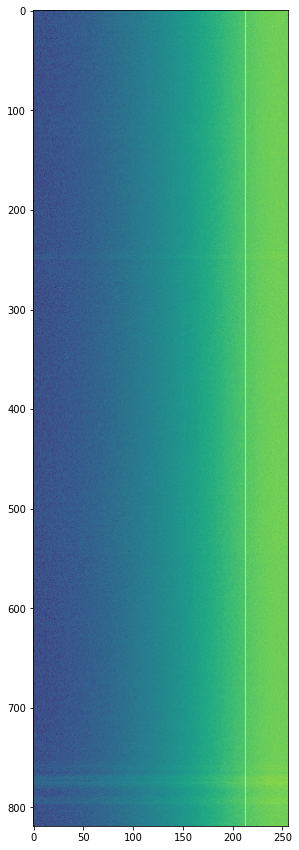

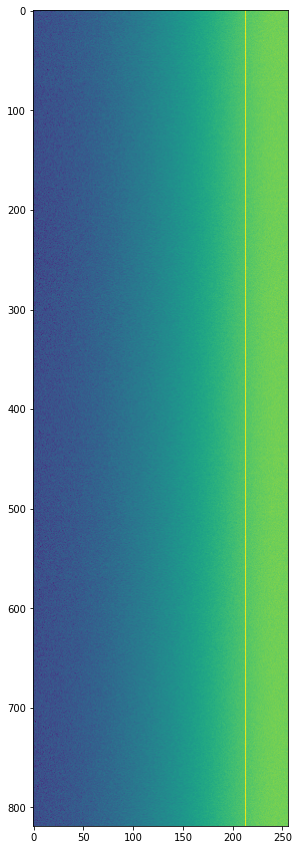

In [109]:
# 32229 - pulse

test_mk["flag"] = "test"
plot_image(test_mk, 30588)

In [82]:
test_mk

id    target  preds_pub    preds2    preds3   preds4  flag
0      00034db451c4  0.013827   0.008421  0.006386  0.005566  0.08010  test
1      0006316b5ca0  0.011379   0.004180  0.005116  0.002907  0.04065  test
2      0006a953d21b  0.025475   0.031801  0.012820  0.034420  0.03880  test
3      0008a33d6695  0.027849   0.026555  0.018140  0.013084  0.05566  test
4      00095b5119fc  0.013285   0.013587  0.004814  0.005800  0.03918  test
...             ...       ...        ...       ...       ...      ...   ...
35842  ffeed3a168de  0.007250   0.004052  0.003899  0.003635  0.02520  test
35843  fff177e32aac  0.015098   0.011442  0.011300  0.007900  0.03165  test
35844  fff7d40b225a  0.011199   0.007755  0.006115  0.005596  0.03363  test
35845  fff8238a709f  0.009535   0.006606  0.003395  0.005123  0.03040  test
35846  fff882b197de  0.005961   0.002933  0.001875  0.002144  0.02383  test

[35847 rows x 7 columns]

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

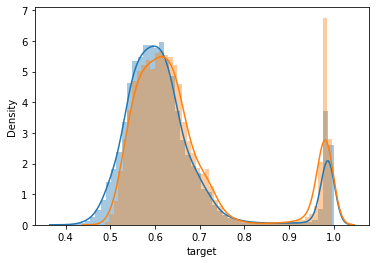

In [41]:
import seaborn as sns
sns.distplot(oof_public['target']**0.1)
sns.distplot(test_public['target']**0.1)

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='target', ylabel='Density'>

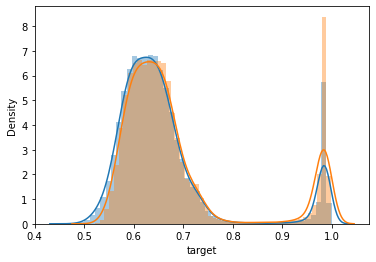

In [42]:
import seaborn as sns
sns.distplot(oof_mk['preds_ee']**0.1)
sns.distplot(test_mk['target']**0.1)

In [54]:
sub['target'] = test_preds_e1
sub.to_csv("data/sub_norm1tta_pub1_gmeanp01.csv", index=False)

In [55]:
sub['target'] = test_preds_mk
sub.to_csv("data/sub_norm1tta.csv", index=False)

In [57]:
easter_ids = ['2503d7f6e5c4',
        '805a7f4cac38',
        'e05a5e667d06',
        '4f7bb8cf2d15',
        '1397c4ab0e5c',
        '1725ceec6de4',
        '6c12bab0aeb4',
        '1e6e43ddc15a',
        '72bc12d576e2']
sub['target'] = test_preds_e1
sub.loc[sub.id.isin(easter_ids), 'target'] = 1.0
sub.to_csv("data/sub_norm1tta_pub1_gmeanp01_manual_easters.csv", index=False)

In [274]:
oof_mk['preds_norm2'] = val_preds2

In [ ]:
from sklearn.linear_model import LogisticRegression


In [351]:
from scipy.stats import gmean
preds = 0.9*np.array(val_preds1)**0.5 + 0.1*np.array(val_preds2)**0.5
roc_auc_score(oof_mk.labels, preds)

0.9897555282686858

In [331]:
oof_mk['preds3'] = preds

In [275]:
oof_mk['preds2'] = oof_mk.id.map(oof_public.set_index('id')['target'])

In [344]:
oof_mk['preds_e2'] = gmean([oof_mk['preds3'], oof_mk['preds2']], 0)

In [345]:
tr = pd.read_csv("data/train_labels.csv")

In [346]:
oof_mk['labels'] = oof_mk.id.map(tr.set_index('id')['target'])

In [347]:
roc_auc_score(oof_mk['labels'].values, oof_mk['preds_e2'].values)

0.9916793537867542

In [509]:
from sklearn.metrics import confusion_matrix
confusion_matrix(oof_mk['target'], oof_mk['preds1'] > 0.7)

array([[45446,    25],
       [  399,  4295]])

In [515]:
fn_ids = oof_mk.loc[(oof_mk['preds1'] < 0.7) & (oof_mk['target'] == 1), "id"]

In [59]:
def plot_image(df, idx):
    ids = df.id.iloc[idx]
    im = np.load(f"data/{df.flag.iloc[idx]}/{ids[0]}/{ids}.npy")[[0, 2, 4]].astype(np.float32)
    #im = im - im.mean(axis=(0, 1), keepdims=True)
    im = np.vstack(im)
    
    im -= im.min()
    im /= im.max()
    plt.figure(figsize=(15, 15))
    plt.imshow(im)
    plt.show()
    return im

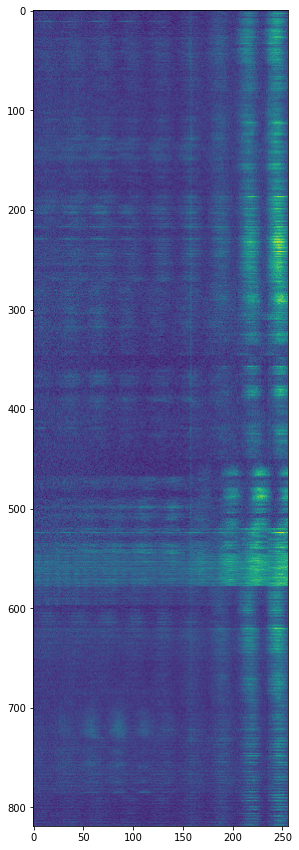

In [60]:
oof_mk['flag'] = "train"
im = plot_image(oof_mk, 1308)

In [1052]:
#tr.loc[tr.target == 1].sample(10)
fn_ids.sample(10)

27752    c4b7f657648e
4304     6e9b216f085e
486      0c40d55c1481
35893    930f318497d1
29422    eee16bde1ede
21535    25ddbcd127c9
5344     887b190beddd
7144     b84cb39f3ac5
16159    9bfd4b516169
36804    a9e6ca59c7b8
Name: id, dtype: object

In [925]:
tr.iloc[22099]

id        704c0efd2f94
target               1
flag             train
Name: 22099, dtype: object

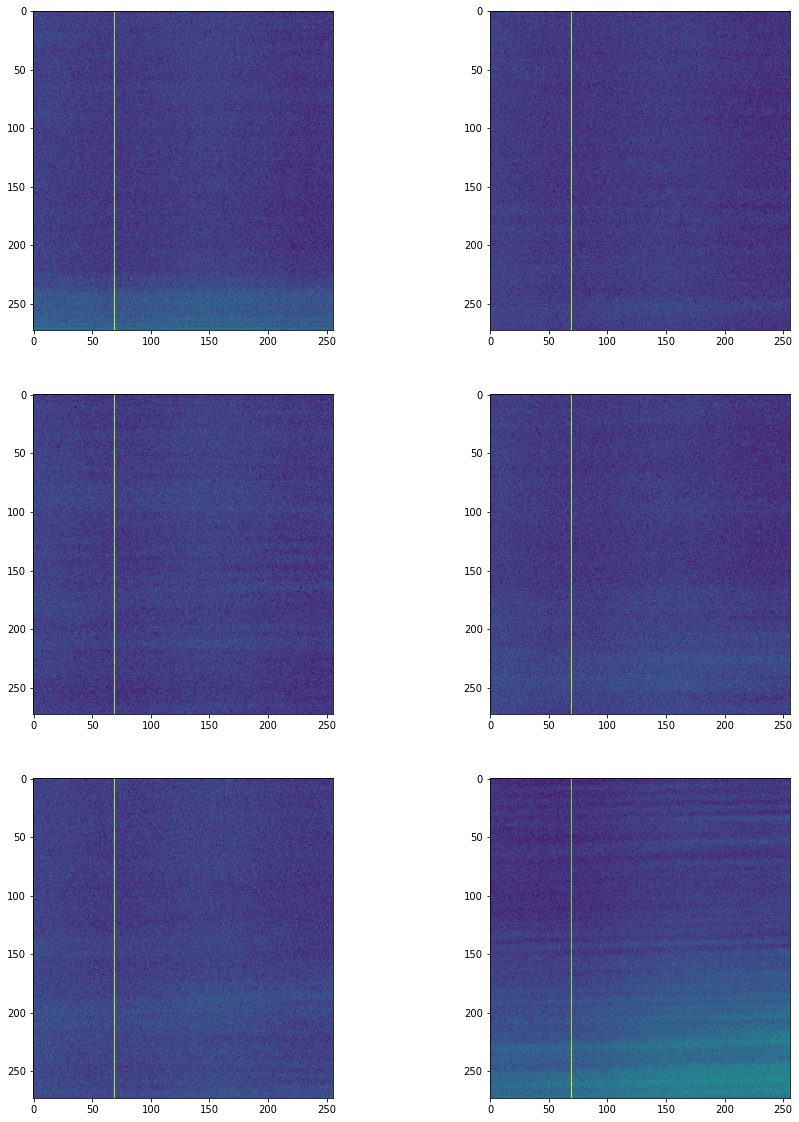

In [1057]:
# nothing - 42109, 48412, # 31259, 34591, 47102, 35584, 38849, 28286, 5286, 22330, 33421, 22419, 13221, 36200, 15868, 28515, 35893, 21701, 16410,
#          47210, 27812, 664, 33690, 1763, 34423,  3217, 8072, 4489, 16405, 14419, 2045, 10211, 10089, 5344, 10198, 30915, 25505, 20155, 29757
# faint - 24459 # 14269, 23819, 21965, 20298, 14265, 2300, 27752, 34927, 22098, 38190, 31379, 14457
# clear as day - # 36598, 24639
# noisy background - 3686, 18849 # 34678, 43242, 5256, 12371, 22, 13045
# higher brightness - 36523
# occluded - 36675
# anamoly w.t other - 34931
idx = 5344
ids = oof_mk.id.iloc[idx]
im = np.load(f"data/train/{ids[0]}/{ids}.npy").astype(np.float32)
im -= im.min()
im /= im.max()
#im = im - im.mean(axis=(0, 1), keepdims=True)
#im = np.vstack(im)igsize=
fig, ax = plt.subplots(3, 2, figsize=(15, 20))
ax[0, 0].imshow(im[0])
ax[0, 1].imshow(im[1])
ax[1, 0].imshow(im[2])
ax[1, 1].imshow(im[3])
ax[2, 0].imshow(im[4])
ax[2, 1].imshow(im[5])


/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


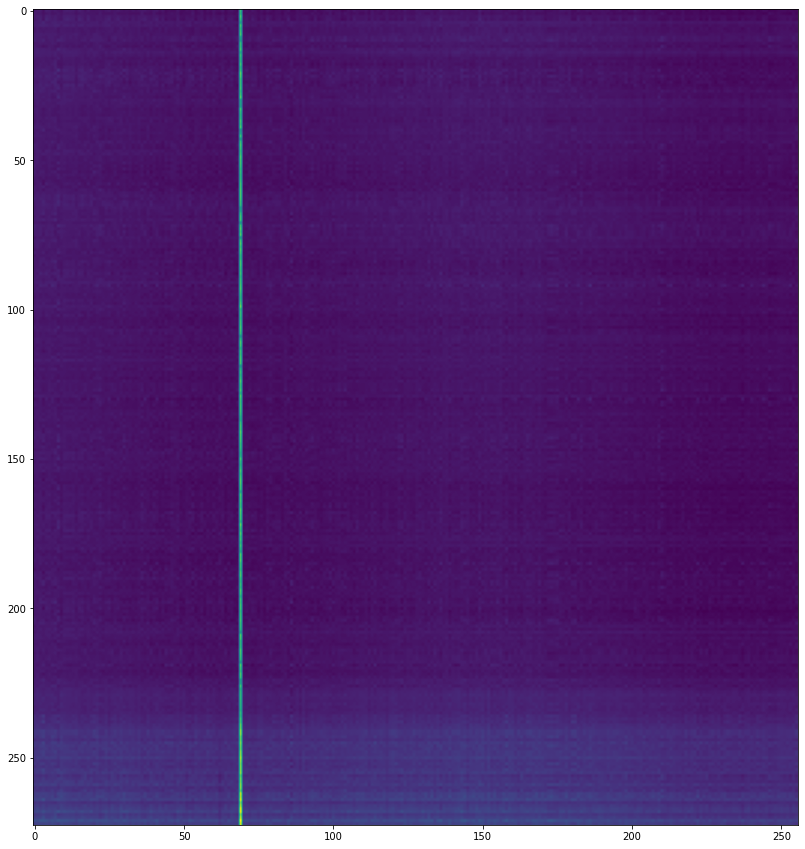

In [1058]:
from sklearn.decomposition import NMF, TruncatedSVD, FastICA
nmf = NMF(8, max_iter=1000, alpha=0.01, solver='mu')  # 
h1 = nmf.fit_transform(im[0])
w1 = nmf.components_
h2 = nmf.fit_transform(im[1])
w2 = nmf.components_
plt.figure(figsize=(15, 15))
plt.imshow((h1 @ w1))

In [1059]:
# from sklearn.preprocessing import QuantileTransformer, PowerTransformer, RobustScaler
# qnt = RobustScaler() # QuantileTransformer(output_distribution='uniform')
# im2 = qnt.fit_transform(im[2].T)
# plt.figure(figsize=(15, 15))
# plt.imshow(im2.T)

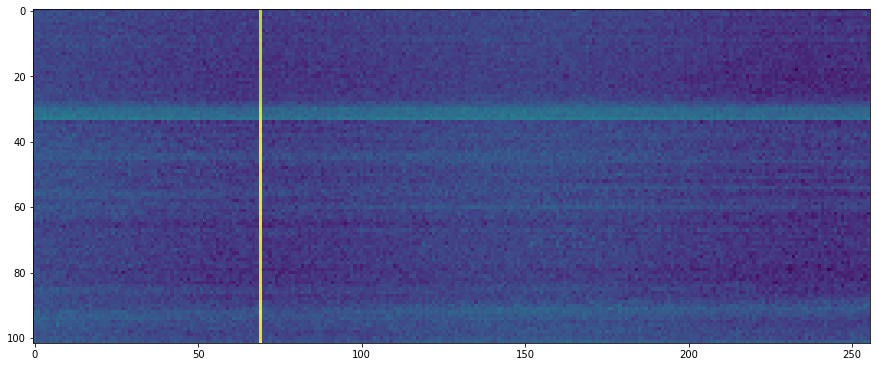

In [1060]:
plt.figure(figsize=(15, 15))
import numpy as np

def rolling_sum(a, n=4) :
    ret = np.cumsum(a, axis=0, dtype=float)
    ret[n:, :] = (ret[n:, :] - ret[:-n, :])
    return np.concatenate((a[:n-1], ret[n - 1:, :]))

im0 = im[0][:272].reshape((8, 34, 256), order='F')
im0 = ((im0 ** 0.3)).sum(axis=0)
im2 = im[2][:272].reshape((8, 34, 256), order='F')
im2 = ((im2 ** 0.3)).sum(axis=0)
im4 = im[4][:272].reshape((8, 34, 256), order='F')
im4 = ((im4 ** 0.3)).sum(axis=0)

#im2 -= im2.mean(axis=(1,), keepdims=True)
plt.imshow(np.vstack((im0, im2, im4)))

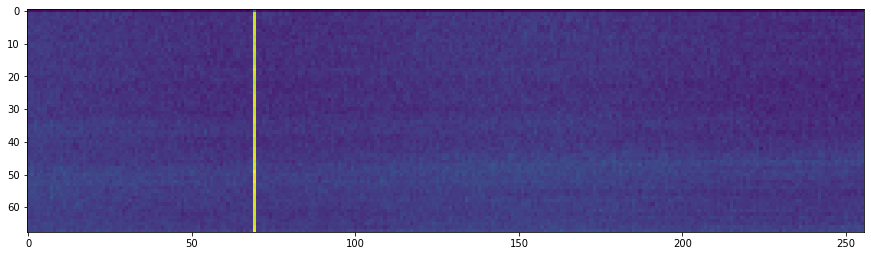

In [1061]:
im2 = rolling_sum(im[4][:272], 4)
im2 = im2.reshape((4, 68, 256), order='F')
im3 = ((im2 ** 1.0)).sum(axis=0)
#im2 -= im2.mean(axis=(1,), keepdims=True)
plt.figure(figsize=(15, 15))
plt.imshow(im3)

In [1051]:
np.sqrt(256*16)

64.0

In [372]:
272/4

68.0

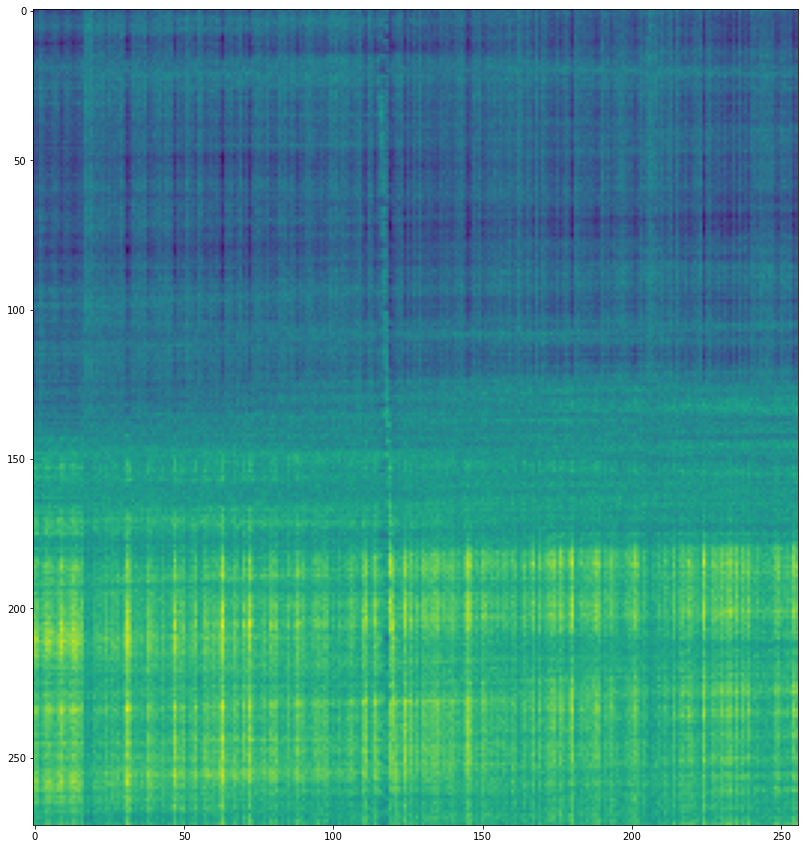

In [406]:
plt.figure(figsize=(15, 15))
plt.imshow((im[0]  - h2@w1))

In [282]:
h1@w1

array([[0.2245694 , 0.22517103, 0.22379887, ..., 0.22503759, 0.2244259 ,
        0.2254695 ],
       [0.22341119, 0.22400971, 0.22264463, ..., 0.22387697, 0.22326842,
        0.22430664],
       [0.22369257, 0.22429185, 0.22292504, ..., 0.22415893, 0.22354962,
        0.22458915],
       ...,
       [0.4472298 , 0.44842798, 0.4456953 , ..., 0.44816223, 0.44694403,
        0.44902238],
       [0.4447304 , 0.44592184, 0.44320446, ..., 0.44565758, 0.4444462 ,
        0.44651294],
       [0.4224839 , 0.42361575, 0.42103428, ..., 0.4233647 , 0.4222139 ,
        0.42417726]], dtype=float32)

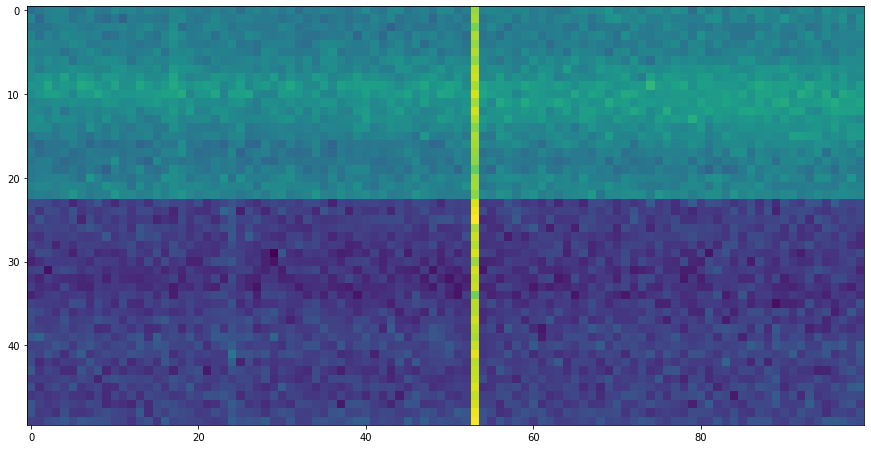

In [239]:
plt.figure(figsize=(15, 15))
plt.imshow(np.vstack(im[[2, 4]])[250:300, 100:200])

In [191]:
h1.shape, w1.shape

((273, 32), (32, 256))

In [283]:
test_public['target'] = test_public['target'] **0.25 * 0.5 + test_preds **0.25 * 0.45 + test_preds2**0.25*0.05

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='preds_e2', ylabel='Density'>

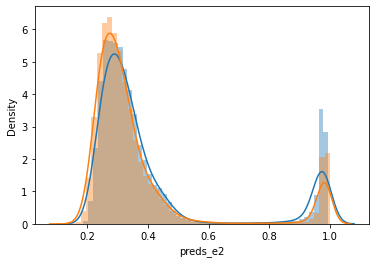

In [284]:
sns.distplot(test_public['target'])
sns.distplot(oof_mk['preds_e2'])

In [285]:
test_public.head()

id    target
0  00034db451c4  0.315221
1  0006316b5ca0  0.300688
2  0006a953d21b  0.377129
3  0008a33d6695  0.395688
4  00095b5119fc  0.368399

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

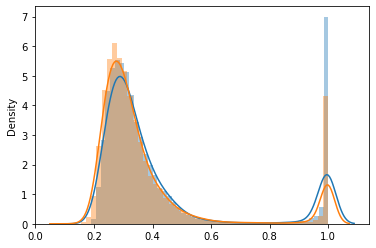

In [292]:
sns.distplot(test_preds**0.25)
sns.distplot(np.array(val_preds1)**0.25)

In [289]:
np.array(val_preds1)

array([0.008644, 0.006878, 0.00784 , ..., 0.01169 , 0.003551, 0.006668],
      dtype=float16)

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

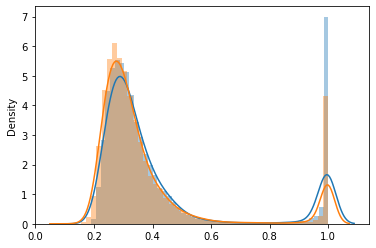

In [290]:
sns.distplot(test_preds**0.25)
sns.distplot(np.array(val_preds1)**0.25)

/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/mohsin_okcredit_in/anaconda3/envs/setienv/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

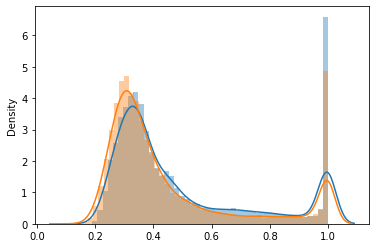

In [291]:
sns.distplot(test_preds2**0.25)
sns.distplot(np.array(val_preds2)**0.25)

In [286]:
test_public.to_csv("data/sub_e5.csv", index=False)

In [28]:
labels

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [359]:
3 * 12

36

In [360]:
model = timm.create_model('efficientnetv2_s', False)
model

EfficientNet(
  (conv_stem): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
      (1): ConvBnAct(
        (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
      )
    )
    (1): Sequential(
      (0): EdgeResidual(
        (conv_exp): Conv2d(24, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, trac

In [ ]:
class SetiCNN4(nn.Module):
    